In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rng

In [2]:
GRID_SIZE = 64
GRID_SIZE_2 = GRID_SIZE ** 2
MID = GRID_SIZE // 2
HMAP_TRIALS = 30
TRIALS = 100
TURNS = 81
EPS = 0.00000001

In [3]:
def init_grids():
    drone_grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=float)
    drone_grid[MID][MID] = DRONES
    return drone_grid, np.ones((GRID_SIZE, GRID_SIZE), dtype=float)


def find_best_max(drone_grid, task_grid, cache=[]):
    best_x, best_y, best_max = 0, 0, task_grid[0][0] * drone_grid[0][0] / DRONES * PHI
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if (x, y) in cache:
                continue
                
            r = task_grid[x][y] * drone_grid[x][y] / DRONES * PHI
                
            if r > best_max + EPS:
                best_x, best_y, best_max = x, y, r
            elif best_max - EPS <= r and r <= best_max + EPS:
                xy_dist = math.sqrt((x - MID - 0.5)**2 + (y - MID - 0.5)**2)
                best_dist = math.sqrt((best_x - MID - 0.5)**2 + (best_y - MID - 0.5)**2)
                if xy_dist < best_dist - EPS:
                    best_x, best_y, best_max = x, y, r
                    
    return (best_x, best_y)


def find_random_cell(grid):
    normal, choice = grid.sum(), rng.uniform(0, 1)
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            choice -= (grid[x][y] / normal)
            if choice <= EPS:
                return (x, y)
    raise Exception("No choice")


def get_cell_weight(grid, x, y, is_cylindrical, ordinal_weight, diagonal_weight, is_ordinal):
    if is_cylindrical:
        return grid[x % GRID_SIZE][y % GRID_SIZE] * (ordinal_weight if is_ordinal else diagonal_weight)
    
    if x < 0 or GRID_SIZE <= x or y < 0 or GRID_SIZE <= y:
        return 0.0
    
    if (x == 0 or x == GRID_SIZE - 1) and (y == 0 or y == GRID_SIZE - 1):
        normal = diagonal_weight + 2 * ordinal_weight
        weight = (ordinal_weight / normal) if is_ordinal else (diagonal_weight / normal)
        return grid[x][y] * weight
    
    if x == 0 or x == GRID_SIZE - 1 or y == 0 or y == GRID_SIZE - 1:
        normal = 2 * diagonal_weight + 3 * ordinal_weight
        weight = (ordinal_weight / normal) if is_ordinal else (diagonal_weight / normal)
        return grid[x][y] * weight
    
    return grid[x][y] * (ordinal_weight if is_ordinal else diagonal_weight)
        

def apply_update(grid, is_cylindrical, ordinal_weight, diagonal_weight, use_alpha=False):
    grid_t = np.zeros((GRID_SIZE, GRID_SIZE), dtype=float)
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            grid_t[x][y] += get_cell_weight(grid, x, y - 1, is_cylindrical, ordinal_weight, diagonal_weight, True)
            grid_t[x][y] += get_cell_weight(grid, x + 1, y, is_cylindrical, ordinal_weight, diagonal_weight, True)
            grid_t[x][y] += get_cell_weight(grid, x, y + 1, is_cylindrical, ordinal_weight, diagonal_weight, True)
            grid_t[x][y] += get_cell_weight(grid, x - 1, y, is_cylindrical, ordinal_weight, diagonal_weight, True)
            
            grid_t[x][y] += get_cell_weight(grid, x - 1, y - 1, is_cylindrical, ordinal_weight, diagonal_weight, False)
            grid_t[x][y] += get_cell_weight(grid, x + 1, y - 1, is_cylindrical, ordinal_weight, diagonal_weight, False)
            grid_t[x][y] += get_cell_weight(grid, x + 1, y + 1, is_cylindrical, ordinal_weight, diagonal_weight, False)
            grid_t[x][y] += get_cell_weight(grid, x - 1, y + 1, is_cylindrical, ordinal_weight, diagonal_weight, False)
            
            if use_alpha:
                grid_t[x][y] *= ALPHA
                grid_t[x][y] += grid[x][y] * (1 - ALPHA)
    return grid_t


def heatmap_experiment(is_cylindrical, ordinal_weight, diagonal_weight, use_max=False):
    drone_grid, task_grid = init_grids()
    reward = np.zeros(TURNS + 1, dtype=float)
    for turn in range(1, TURNS + 1):
        drone_grid = apply_update(drone_grid, is_cylindrical, ordinal_weight, diagonal_weight)
        task_grid = apply_update(task_grid, is_cylindrical, ordinal_weight, diagonal_weight, use_alpha=True) 
        for _ in range(DRONES):
            x, y = None, None
            if use_max:
                x, y = find_best_max(drone_grid, task_grid)
            else:
                x, y = find_random_cell(drone_grid)
            task_grid[x][y] *= (1.0 - PHI)
        reward[turn] = (GRID_SIZE_2 - task_grid.sum()) / GRID_SIZE_2
    return reward


def experiment(is_cylindrical, ordinal_weight, diagonal_weight, use_max=False):
    final_reward = np.zeros(TURNS + 1, dtype=float)
    for trial in range(HMAP_TRIALS):
        final_reward += heatmap_experiment(is_cylindrical, ordinal_weight, diagonal_weight, use_max=use_max)
    final_reward /= HMAP_TRIALS
    return final_reward

In [53]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.75
neumann = experiment(False, 0.25, 0)

In [54]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.75
moore = experiment(False, 0.125, 0.125)

In [55]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.75
neumann_cyl = experiment(True, 0.25, 0)

In [56]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.75
moore_cyl = experiment(True, 0.125, 0.125)

In [57]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.75
moore_diff = experiment(False, 0.175, 0.075)

In [58]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.75
moore_diff_cyl = experiment(True, 0.175, 0.075)

In [4]:
def get_random_neighbor(x, y, use_alpha=False):
    if use_alpha and rng.uniform(0, 1) > ALPHA:
        return (x, y)
    
    x_prime, y_prime = x, y
    while x_prime == x and y_prime == y:
        angle = rng.uniform(0, 2 * math.pi)
        vx = x + 0.5 + math.cos(angle) * math.sqrt(2)
        vy = y + 0.5 + math.sin(angle) * math.sqrt(2)
        
        if math.floor(vx + EPS) == x and math.floor(vy + EPS) == y:
            raise Exception("Invalid move angle")
        
        while vx < 0 or GRID_SIZE < vx:
            vx = abs(vx) if vx < 0 else vx
            vx = (2 * GRID_SIZE - vx) if GRID_SIZE < vx else vx
            
        while vy < 0 or GRID_SIZE < vy:
            vy = abs(vy) if vy < 0 else vy
            vy = (2 * GRID_SIZE - vy) if GRID_SIZE < vy else vy
            
        x_prime, y_prime = min(GRID_SIZE - 1, math.floor(vx + EPS)), min(GRID_SIZE - 1, math.floor(vy + EPS))
    return (x_prime, y_prime)


def get_neighbors(x, y, exclude_middle=False):
    neighbors = [(i, j) for j in range(max(y-1, 0), min(y+1, GRID_SIZE-1)+1) for i in range(max(x-1, 0), min(x+1, GRID_SIZE-1)+1)]
    if exclude_middle:
        return list(filter(lambda loc: loc[0] != x or loc[1] != y, neighbors))
    return neighbors


def get_best_neighbor(x, y, drone_map=None, task_map=None, no_colls=0):
    if task_map is None or len(task_map) == 0:
        return get_random_neighbor(x, y)
    
    if no_colls == -1:
        for neighbor in get_neighbors(x, y):
            if drone_map[neighbor[0], neighbor[1]] == 1:
                task_map[neighbor[0], neighbor[1]] = 0

    neighbors = list(filter(lambda loc: task_map[loc[0], loc[1]] == 1, get_neighbors(x, y)))
    
    if no_colls != 0:
        neighbors_prime = list(filter(lambda loc: drone_map[loc[0], loc[1]] == 0, neighbors))
        if len(neighbors_prime) > 0:
            neighbors = neighbors_prime

    choice = None
    if neighbors is None or len(neighbors) == 0:
        choice = get_random_neighbor(x, y)
    else:
        choice = rng.choice(neighbors)

    if no_colls != 0:
        drone_map[choice[0], choice[1]] += 1
        
    return choice


def mow_grid(turn, x, y, drone_id=0):
    if drone_id > 6 * (turn - 1):
        return (x, y)
    
    prev_direction = ((turn - 1 + MID - min((drone_id+5)//6, 5)) // GRID_SIZE) % 2
    direction = ((turn + MID - min((drone_id+5)//6, 5)) // GRID_SIZE) % 2
    
    if prev_direction == 0 and direction == 1:
        return (x, (y + 1) if y < GRID_SIZE - 1 else (y - 1))
    elif prev_direction == 1 and direction == 0:
        return (x, (y - 1) if y > 0 else (y + 1))
    elif direction == 0:
        if x == GRID_SIZE - 1:
            raise Exception(f"cannot mow {turn}:{drone_id}")
        return (min(x+1, GRID_SIZE-1), y)
    else:
        if x == 0:
            raise Exception(f"cannot mow {turn}:{drone_id}")
        return (max(x-1, 0), y)


def whirl_grid(turn, x, y, drone_id, use_id=False, task_map=None):
    if use_id and drone_id != 0 and turn <= 1:
        return (x, y)
    shell, position = get_shell_position(x, y)
    if task_map is None or len(task_map) == 0:
        if drone_id == 0 and position == 0:
            return get_position_from(shell + 1, 1)
        elif drone_id == 0:
            return get_position_from(shell, position + 1)
        else:
            shell_len = 8*shell
            offset = shell_len / (DRONES - 1)
            partition = math.floor(offset * (drone_id + shell - 6) + EPS)
            if position < partition:
                return get_position_from(shell, position + 1)
            else:
                shell_len = 8*(shell + 1)
                offset = shell_len / (DRONES - 1)
                partition = math.floor(offset * (drone_id + shell - 6) + EPS)
                return get_position_from(shell + 1, partition)
    shell_len = 8*shell
    if shell_len == 0:
        return get_position_from(shell + 1, 1)
    dx, dy = get_position_from(shell, (position + 1) % shell_len)
    if task_map[dx, dy] == 0:
        neighbors = get_neighbors(x, y, exclude_middle=True)
        neighbors = list(filter(lambda loc: get_shell_position(loc[0], loc[1])[0] == shell+1, neighbors))
        neighbors.sort(key=lambda loc: get_shell_position(loc[0], loc[1])[1])
        neighbors_prime = list(filter(lambda loc: task_map[loc[0], loc[1]] > 0, neighbors))
        if len(neighbors_prime) > 0:
            neighbors = neighbors_prime
        return neighbors[-1]
    else:
        return (dx, dy)
    
    
def get_shell_position(x, y):
    dx, dy = x - MID, y - MID
    shell = max(abs(dx), abs(dy))
    if shell == 0:
        return (shell, 0)
    if abs(dx) == shell and dx < 0:
        return (shell, shell + dy)
    elif abs(dy) == shell and dy > 0:
        return (shell, 3*shell + dx)
    elif abs(dx) == shell and dx > 0:
        return (shell, 5*shell - dy)
    else:
        return (shell, 7*shell - dx)

    
def get_position_from(shell, pos):
    cx, cy = MID - shell, MID - shell
    if pos <= 2*shell:
        return (cx, cy + pos)
    elif pos <= 4*shell:
        return (cx + pos - 2*shell, cy + 2*shell)
    elif pos <= 6*shell:
        return (cx + 2*shell, cy + 2*shell - (pos - 4*shell))
    else:
        return (cx + 2*shell - (pos - 6*shell), cy)


def place_drones(random_placement=0, mow=0, quad=0, whirl=0):
    drones = None
    if mow != 0:
        offset = GRID_SIZE//DRONES
        drones = [(MID, offset * i) for i in range(DRONES)]
        drones.sort(key=lambda loc: abs(loc[1] - MID))
#         while len(drones) < DRONES:
#             drones.append((MID, MID))
#             x, j = GRID_SIZE//DRONES, 1
#             while len(drones) < DRONES and 2*x*j <= GRID_SIZE:
#                 if MID + x*j < GRID_SIZE:
#                     drones.append((MID, MID + x*j))
#                 if len(drones) < DRONES and MID - x*j >= 0:
#                     drones.append((MID, MID - x*j))
#                 j += 1
#             j = 1
#             while len(drones) < DRONES and 2*x*j < GRID_SIZE:
#                 if MID + x*j + 1 < GRID_SIZE:
#                     drones.append((MID, MID + x*j + 1))
#                 if len(drones) < DRONES and MID - x*j + 1 >= 0:
#                     drones.append((MID, MID - x*j + 1))
#                 j += 1
    elif quad != 0:
        x = DRONES//4
        drones = [(i, j) for j in range(0, GRID_SIZE, GRID_SIZE//4) for i in range(0, GRID_SIZE, GRID_SIZE//x)]
    elif whirl != 0:
        shell_len = 8*6
        offset = shell_len / (DRONES - 1)
        drones = [(MID, MID)] + [get_position_from(6, math.floor(offset*i + EPS) % shell_len) for i in range(1, DRONES)]
    elif (random_placement & 2) != 0:
        drones = [(rng.randrange(1, GRID_SIZE - 1), rng.randrange(1, GRID_SIZE - 1)) for _ in range(DRONES)]
    else:
        drones = [(MID, MID) for _ in range(DRONES)]
    return drones


def place_tasks(random_placement=0):
    tasks = None
    if (random_placement & 1) != 0:
        tasks = [(rng.randrange(GRID_SIZE), rng.randrange(GRID_SIZE)) for _ in range(TASKS)]
    else:
        tasks = [(i, j) for j in range(GRID_SIZE) for i in range(GRID_SIZE)]
    return tasks


def sim_random_walk(random_placement=0, use_motion=False, mow=0, whirl=0, quad=0, be_selfish=False, be_oblivious=False, no_colls=0, repeat_scans=False, use_loss=0):
    drones = place_drones(random_placement=random_placement, mow=mow, whirl=whirl, quad=quad)
    drone_map = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    
    if mow == 1 or whirl == 1:
        drone_map[drones[0][0], drones[0][1]] += 1
    else:
        for drone in drones:
            drone_map[drone[0], drone[1]] += 1

    tasks = place_tasks(random_placement=random_placement)
    num_tasks = len(tasks)
    task_map = None
    if be_oblivious:
        task_map = np.ones((DRONES, GRID_SIZE, GRID_SIZE))
        for i, drone in enumerate(drones):
            task_map[i, drone[0], drone[1]] = 0
    else:
        task_map = np.ones((GRID_SIZE, GRID_SIZE))
        task_map[MID, MID] = 0
    
    loss_points = None
    if use_loss > 0:
        loss_points = list(sorted([rng.randint(7, TURNS + 1) for _ in range(use_loss)]))

    reward = np.zeros(TURNS + 1, dtype=float)
    for turn in range(1, TURNS + 1):
        if be_oblivious and no_colls != 0:
            for i, drone in enumerate(drones):
                for neighbor in get_neighbors(drone[0], drone[1]):
                    if drone_map[neighbor[0], neighbor[1]] == 1:
                        task_map[i, neighbor[0], neighbor[1]] = 0
                        
        for drone in drones:
            drone_map[drone[0], drone[1]] = 0
        
        if not (loss_points is None):
            while len(loss_points) > 0 and turn == loss_points[0]:
                drones.pop(rng.choice(list(range(len(drones)))))
                loss_points.pop(0)
            
        if mow != 0:
            drones = [mow_grid(turn, drone[0], drone[1], i if mow == 1 else 0) for i, drone in enumerate(drones)]
        elif whirl != 0:
            drones = [whirl_grid(turn, drone[0], drone[1], i, use_id=(whirl==1), task_map=task_map) for i, drone in enumerate(drones)]
        elif be_selfish and be_oblivious:
            drones = [get_best_neighbor(drone[0], drone[1], drone_map=drone_map, task_map=task_map[i], no_colls=no_colls) for i, drone in enumerate(drones)]
        elif be_selfish:
            drones = [get_best_neighbor(drone[0], drone[1], drone_map=drone_map, task_map=task_map, no_colls=no_colls) for drone in drones]
        else:
            drones = [get_random_neighbor(drone[0], drone[1]) for drone in drones]
        
        if no_colls:
            for drone in drones:
                drone_map[drone[0], drone[1]] = 0

        for i, drone in enumerate(drones):
            if mow != 0:
                if mow != 1 or (mow == 1 and i <= 6 * (turn - 1)):
                    drone_map[drone[0], drone[1]] += 1
            elif whirl != 0:
                if whirl != 1 or (whirl == 1 and (turn > 1 or i == 0)):
                    drone_map[drone[0], drone[1]] += 1
            else:
                drone_map[drone[0], drone[1]] += 1
            if be_oblivious:
                task_map[i, drone[0], drone[1]] = 0
            else:
                task_map[drone[0], drone[1]] = 0
                
        tasks_t = []
        for task in tasks:
            detected = False
            if repeat_scans:
                for _ in range(drone_map[task[0], task[1]]):
                    if rng.uniform(0, 1) < PHI:
                        detected = True
            else:
                detected = drone_map[task[0], task[1]] > 0 and rng.uniform(0, 1) < PHI
            if detected:
                continue
                
            if not use_motion:
                tasks_t.append(task)
                continue

            tasks_t.append(get_random_neighbor(task[0], task[1], use_alpha=True))
        tasks = tasks_t
        
        reward[turn] = (num_tasks - len(tasks)) / num_tasks
    return reward


def random_walk_experiment(random_placement=0, use_motion=False, mow=0, whirl=0, quad=0, be_selfish=False, be_oblivious=False, no_colls=0, repeat_scans=False, use_loss=0):
    final_reward = np.zeros(TURNS + 1, dtype=float)
    for trial in range(TRIALS):
        final_reward += sim_random_walk(random_placement=random_placement, use_motion=use_motion, mow=mow, whirl=whirl, quad=quad, be_selfish=be_selfish, be_oblivious=be_oblivious, no_colls=no_colls, repeat_scans=repeat_scans, use_loss=use_loss)
    final_reward /= TRIALS
    return final_reward

In [15]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.0, 1.0
random_explore = random_walk_experiment()

In [39]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 1.0, 1.0
random_explore_selfish_oblivious = random_walk_experiment(be_selfish=True, be_oblivious=True)

In [40]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 1.0, 1.0
random_explore_selfish = random_walk_experiment(be_selfish=True, be_oblivious=False)

In [41]:
[random_explore[-1], random_explore_selfish_oblivious[-1], random_explore_selfish[-1]]

[0.13659423828125, 0.2514990234375, 0.46505615234375]

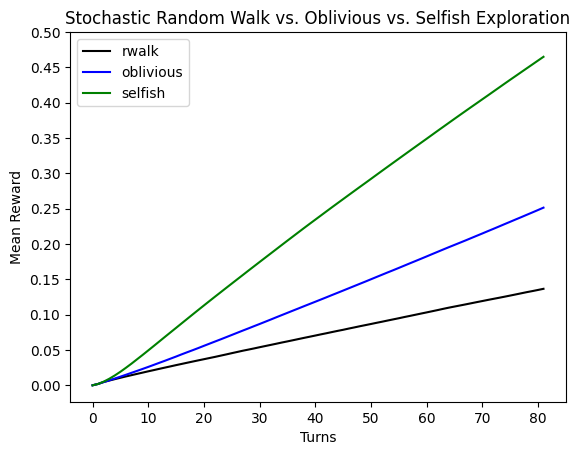

In [42]:
x_labels = ['rwalk', 'oblivious', 'selfish']
x_colors = ['black', 'blue', 'green']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, random_explore, label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, random_explore_selfish_oblivious, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, random_explore_selfish, label=x_labels[2], color=x_colors[2])

plt.title(f'Stochastic Random Walk vs. Oblivious vs. Selfish Exploration')
plt.xlabel('Turns')
plt.ylabel('Mean Reward')
plt.yticks(np.arange(0, 0.55, step=0.05))
plt.legend()

In [43]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 1.0, 1.0
random_explore_selfish_oblivious_min_colls = random_walk_experiment(be_selfish=True, be_oblivious=True, no_colls=1)

In [44]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 1.0, 1.0
random_explore_selfish_min_colls = random_walk_experiment(be_selfish=True, no_colls=1)

In [45]:
[random_explore_selfish_oblivious_min_colls[-1], random_explore_selfish_min_colls[-1]]

[0.29843017578125, 0.494326171875]

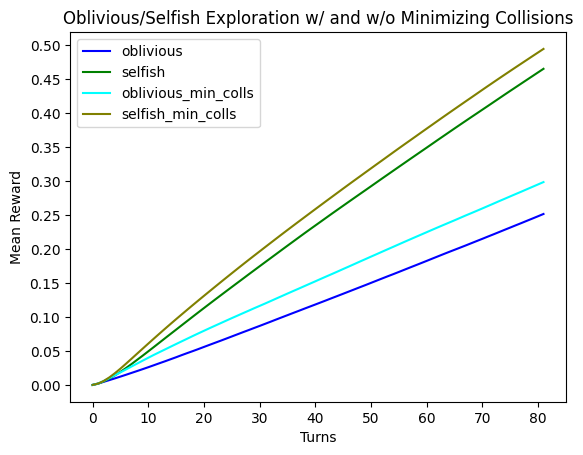

In [46]:
x_labels = ['oblivious', 'selfish', 'oblivious_min_colls', 'selfish_min_colls']
x_colors = ['blue', 'green', 'cyan', 'olive']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, random_explore_selfish_oblivious, label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, random_explore_selfish, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, random_explore_selfish_oblivious_min_colls, label=x_labels[2], color=x_colors[2])
plt.plot(x_axis, random_explore_selfish_min_colls, label=x_labels[3], color=x_colors[3])

plt.title(f'Oblivious/Selfish Exploration w/ and w/o Minimizing Collisions')
plt.xlabel('Turns')
plt.ylabel('Mean Reward')
plt.yticks(np.arange(0, 0.55, step=0.05))
plt.legend()

In [47]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 1.0, 1.0
random_explore_selfish_no_colls = random_walk_experiment(be_selfish=True, no_colls=-1)

In [48]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 1.0, 1.0
random_explore_oblivious_selfish_no_colls = random_walk_experiment(be_selfish=True, be_oblivious=True, no_colls=-1)

In [49]:
[random_explore_selfish_no_colls[-1], random_explore_oblivious_selfish_no_colls[-1]]

[0.430732421875, 0.3005517578125]

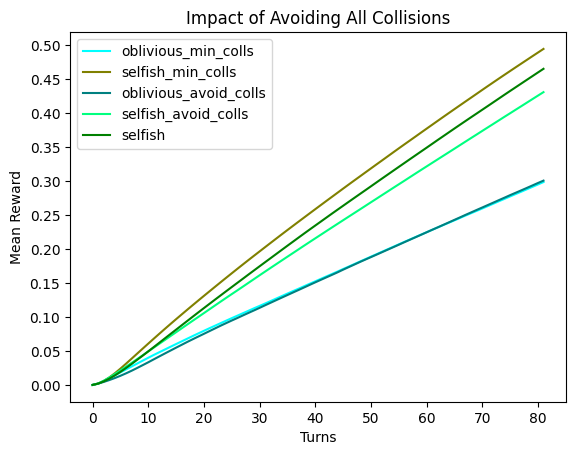

In [50]:
x_labels = ['oblivious_min_colls', 'selfish_min_colls', 'oblivious_avoid_colls', 'selfish_avoid_colls', 'selfish']
x_colors = ['cyan', 'olive', 'teal', 'springgreen', 'green']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, random_explore_selfish_oblivious_min_colls, label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, random_explore_selfish_min_colls, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, random_explore_oblivious_selfish_no_colls, label=x_labels[2], color=x_colors[2])
plt.plot(x_axis, random_explore_selfish_no_colls, label=x_labels[3], color=x_colors[3])
plt.plot(x_axis, random_explore_selfish, label=x_labels[4], color=x_colors[4])

plt.title(f'Impact of Avoiding All Collisions')
plt.xlabel('Turns')
plt.ylabel('Mean Reward')
plt.yticks(np.arange(0, 0.55, step=0.05))
plt.legend()

In [51]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 1.0, 1.0
random_explore_selfish_rng = random_walk_experiment(random_placement=2, be_selfish=True)

In [10]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.0, 1.0
random_explore_selfish_min_colls_rng = random_walk_experiment(random_placement=2, be_selfish=True, no_colls=1)

In [53]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 1.0, 1.0
random_explore_selfish_no_colls_rng = random_walk_experiment(random_placement=2, be_selfish=True, no_colls=-1)

In [11]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.0, 1.0
random_explore_selfish_oblivious_min_colls_rng = random_walk_experiment(random_placement=2, be_selfish=True, be_oblivious=True, no_colls=1)

In [55]:
[random_explore_selfish_rng[-1], random_explore_selfish_min_colls_rng[-4], random_explore_selfish_no_colls_rng[-1], random_explore_selfish_oblivious_min_colls_rng[-1]]

[0.56142578125, 0.55514892578125, 0.56886474609375, 0.4758984375]

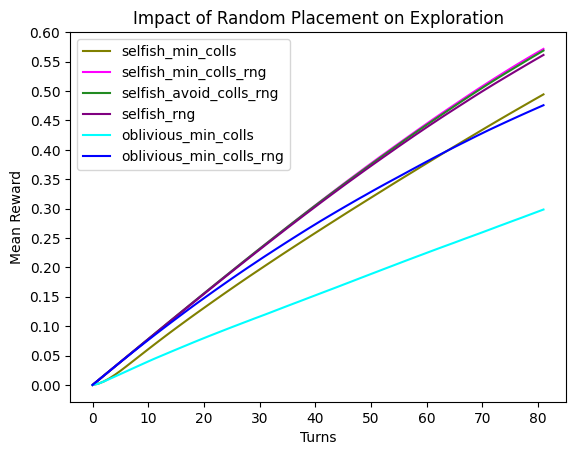

In [56]:
x_labels = ['selfish_min_colls', 'selfish_min_colls_rng', 'selfish_avoid_colls_rng', 'selfish_rng', 'oblivious_min_colls', 'oblivious_min_colls_rng']
x_colors = ['olive', 'magenta', 'forestgreen', 'purple', 'cyan', 'blue']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, random_explore_selfish_min_colls, label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, random_explore_selfish_min_colls_rng, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, random_explore_selfish_no_colls_rng, label=x_labels[2], color=x_colors[2])
plt.plot(x_axis, random_explore_selfish_rng, label=x_labels[3], color=x_colors[3])
plt.plot(x_axis, random_explore_selfish_oblivious_min_colls, label=x_labels[4], color=x_colors[4])
plt.plot(x_axis, random_explore_selfish_oblivious_min_colls_rng, label=x_labels[5], color=x_colors[5])


plt.title(f'Impact of Random Placement on Exploration')
plt.xlabel('Turns')
plt.ylabel('Mean Reward')
plt.yticks(np.arange(0, 0.65, step=0.05))
plt.legend()

In [12]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.0, 1.0
mow_explore = random_walk_experiment(mow=1)

In [13]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.0, 1.0
whirl_explore = random_walk_experiment(whirl=1)

In [59]:
[mow_explore[-1], whirl_explore[-1]]

[0.609375, 0.625244140625]

In [14]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.0, 1.0
quad_explore = random_walk_experiment(quad=1)

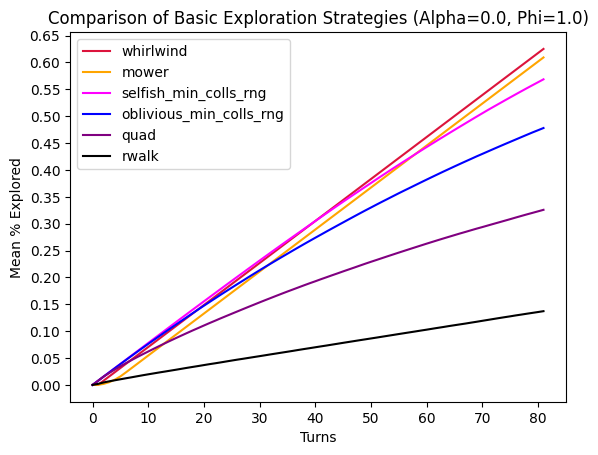

In [33]:
x_labels = ['selfish_min_colls_rng', 'oblivious_min_colls_rng', 'rwalk', 'mower', 'whirlwind', 'quad']
x_colors = ['magenta', 'blue', 'black', 'orange', 'crimson', 'purple']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, whirl_explore, label=x_labels[4], color=x_colors[4])
plt.plot(x_axis, mow_explore, label=x_labels[3], color=x_colors[3])
plt.plot(x_axis, random_explore_selfish_min_colls_rng, label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, random_explore_selfish_oblivious_min_colls_rng, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, quad_explore, label=x_labels[5], color=x_colors[5])
plt.plot(x_axis, random_explore, label=x_labels[2], color=x_colors[2])

plt.title(f'Comparison of Basic Exploration Strategies (Alpha=0.0, Phi=1.0)')
plt.xlabel('Turns')
plt.ylabel('Mean % Explored')
plt.yticks(np.arange(0, 0.70, step=0.05))
plt.legend()

In [19]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.875, 1.0
random_explore_m = random_walk_experiment(random_placement=1, use_motion=True)

In [20]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.875, 1.0
random_explore_selfish_min_colls_rng_m = random_walk_experiment(random_placement=3, use_motion=True, be_selfish=True, no_colls=1)

In [63]:
[random_explore_m[-1], random_explore_selfish_min_colls_rng_m[-1]]

[0.15649169921875, 0.390830078125]

In [24]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.875, 1.0
random_explore_selfish_oblivious_min_colls_rng_m = random_walk_experiment(random_placement=2, use_motion=True, be_selfish=True, be_oblivious=True, no_colls=1)

In [21]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.875, 1.0
whirl_explore_m = random_walk_experiment(whirl=1, random_placement=1, use_motion=True)

In [22]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.875, 1.0
mow_explore_m = random_walk_experiment(mow=1, random_placement=1, use_motion=True)

In [66]:
[mow_explore_m[-1], whirl_explore_m[-1]]

[0.42372802734375, 0.3785986328125]

In [23]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.875, 1.0
quad_explore_m = random_walk_experiment(quad=1, random_placement=1, use_motion=True)

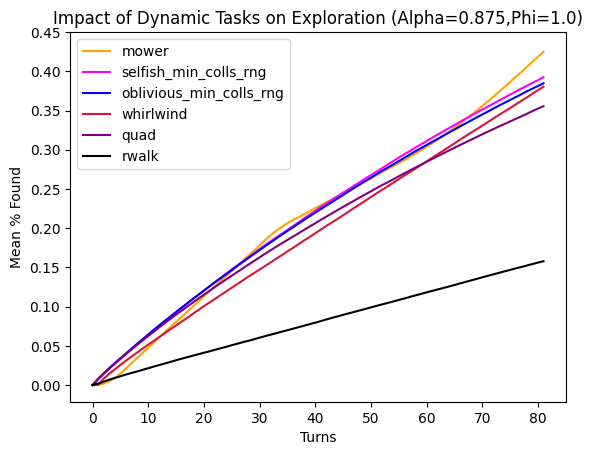

In [37]:
x_labels = ['rwalk', 'selfish_min_colls_rng', 'selfish_min_colls_rng_dynamic', 'mower', 'mow_dynamic', 'whirlwind', 'whirl_dynamic', 'quad', 'quad_dynamic', 'oblivious_min_colls_rng', 'oblivious_min_colls_rng_dynamic']
x_colors = ['black', 'magenta', 'green', 'orange', 'gold', 'crimson', 'deeppink', 'purple', 'deeppurple', 'blue', 'deepblue']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, mow_explore_m, label=x_labels[3], color=x_colors[3])
plt.plot(x_axis, random_explore_selfish_min_colls_rng_m, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, random_explore_selfish_oblivious_min_colls_rng_m, label=x_labels[9], color=x_colors[9])
plt.plot(x_axis, whirl_explore_m, label=x_labels[5], color=x_colors[5])
plt.plot(x_axis, quad_explore_m, label=x_labels[7], color=x_colors[7])
plt.plot(x_axis, random_explore_m, label=x_labels[0], color=x_colors[0])
# plt.plot(x_axis, random_explore_selfish_min_colls_rng, label=x_labels[1], color=x_colors[1])
# plt.plot(x_axis, mow_explore, label=x_labels[3], color=x_colors[3])
# plt.plot(x_axis, whirl_explore, label=x_labels[5], color=x_colors[5])

plt.title(f'Impact of Dynamic Tasks on Exploration (Alpha={ALPHA:.3f},Phi={PHI:.1f})')
plt.xlabel('Turns')
plt.ylabel('Mean % Found')
plt.yticks(np.arange(0, 0.50, step=0.05))
plt.legend()

In [340]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.875, 0.75
random_explore_m2 = random_walk_experiment(random_placement=1, use_motion=True)

In [341]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.875, 0.75
random_explore_selfish_min_colls_rng_m2 = random_walk_experiment(random_placement=3, use_motion=True, be_selfish=True, no_colls=1)

In [342]:
[random_explore_m2[-1], random_explore_selfish_min_colls_rng_m2[-1]]

[0.141318359375, 0.325126953125]

In [343]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.875, 0.75
whirl_explore_m2 = random_walk_experiment(whirl=1, random_placement=1, use_motion=True)

In [344]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.875, 0.75
mow_explore_m2 = random_walk_experiment(mow=1, random_placement=1, use_motion=True)

In [345]:
[mow_explore_m2[-1], whirl_explore_m2[-1]]

[0.34673828125, 0.31537841796875]

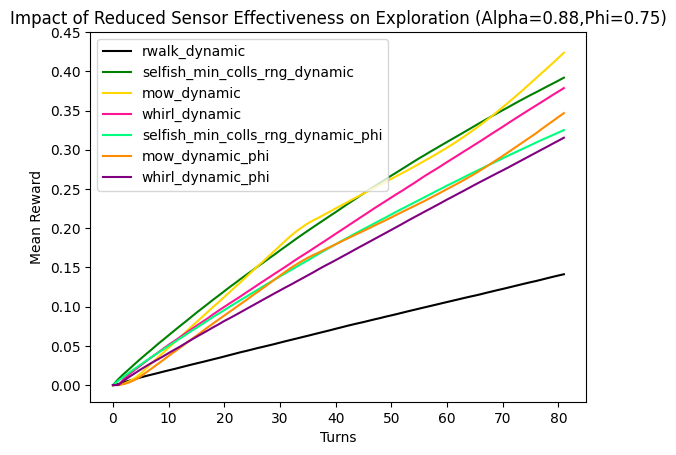

In [347]:
x_labels = ['rwalk_dynamic', 'selfish_min_colls_rng_dynamic', 'mow_dynamic', 'whirl_dynamic', 'selfish_min_colls_rng_dynamic_phi', 'mow_dynamic_phi', 'whirl_dynamic_phi']
x_colors = ['black', 'green', 'gold', 'deeppink', 'springgreen', 'darkorange', 'purple']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, random_explore_m2, label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, random_explore_selfish_min_colls_rng_m, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, mow_explore_m, label=x_labels[2], color=x_colors[2])
plt.plot(x_axis, whirl_explore_m, label=x_labels[3], color=x_colors[3])
plt.plot(x_axis, random_explore_selfish_min_colls_rng_m2, label=x_labels[4], color=x_colors[4])
plt.plot(x_axis, mow_explore_m2, label=x_labels[5], color=x_colors[5])
plt.plot(x_axis, whirl_explore_m2, label=x_labels[6], color=x_colors[6])

plt.title(f'Impact of Reduced Sensor Effectiveness on Exploration (Alpha={(1-ALPHA):.2f},Phi={PHI:.2f})')
plt.xlabel('Turns')
plt.ylabel('Mean Reward')
plt.yticks(np.arange(0, 0.50, step=0.05))
plt.legend()

In [60]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.75
random_explore_dynamic = random_walk_experiment(random_placement=1, use_motion=True)

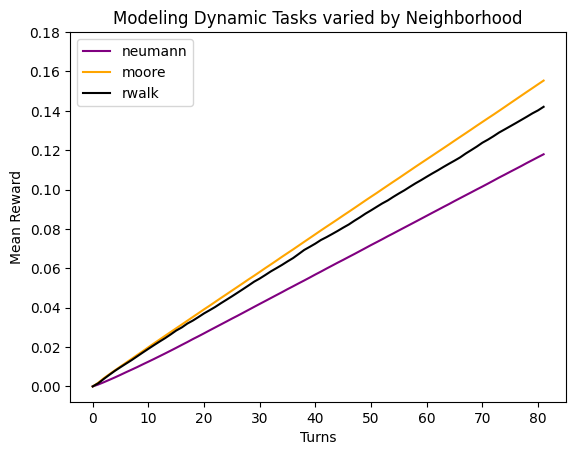

In [359]:
x_labels = ['neumann', 'moore', 'rwalk']
x_colors = ['purple', 'orange', 'black']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, neumann, label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, moore, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, random_explore_dynamic, label=x_labels[2], color=x_colors[2])

plt.title(f'Modeling Dynamic Tasks by Neighborhood (Alpha={(1-ALPHA):.2f},Phi={PHI:.2f})')
plt.xlabel('Turns')
plt.ylabel('Mean Reward')
plt.yticks(np.arange(0, 0.2, step=0.02))
plt.legend()

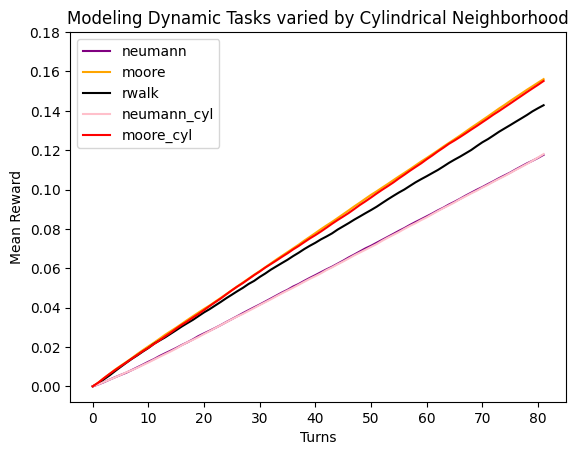

In [62]:
x_labels = ['neumann', 'moore', 'rwalk', 'neumann_cyl', 'moore_cyl']
x_colors = ['purple', 'orange', 'black', 'pink', 'red']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, neumann, label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, moore, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, random_explore_dynamic, label=x_labels[2], color=x_colors[2])
plt.plot(x_axis, neumann_cyl, label=x_labels[3], color=x_colors[3])
plt.plot(x_axis, moore_cyl, label=x_labels[4], color=x_colors[4])

plt.title(f'Modeling Dynamic Tasks varied by Cylindrical Neighborhood')
plt.xlabel('Turns')
plt.ylabel('Mean Reward')
plt.yticks(np.arange(0, 0.2, step=0.02))
plt.legend()

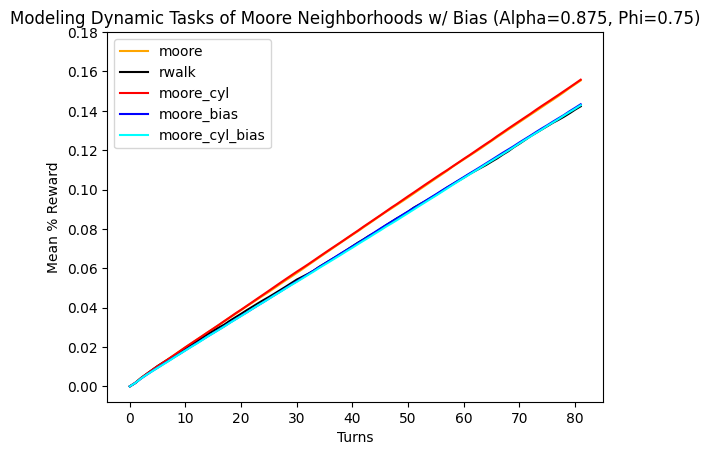

In [61]:
x_labels = ['neumann', 'moore', 'rwalk', 'neumann_cyl', 'moore_cyl', 'moore_bias', 'moore_cyl_bias']
x_colors = ['purple', 'orange', 'black', 'pink', 'red', 'blue', 'cyan']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, moore, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, random_explore_dynamic, label=x_labels[2], color=x_colors[2])
plt.plot(x_axis, moore_cyl, label=x_labels[4], color=x_colors[4])
plt.plot(x_axis, moore_diff, label=x_labels[5], color=x_colors[5])
plt.plot(x_axis, moore_diff_cyl, label=x_labels[6], color=x_colors[6])

plt.title(f'Modeling Dynamic Tasks of Moore Neighborhoods w/ Bias (Alpha=0.875, Phi=0.75)')
plt.xlabel('Turns')
plt.ylabel('Mean % Reward')
plt.yticks(np.arange(0, 0.2, step=0.02))
plt.legend()

In [ ]:
[
    np.square((random_walk - neumann)).mean(),
    np.square((random_walk - neumann_cyl)).mean(),
    np.square((random_walk - moore)).mean(),
    np.square((random_walk - moore_diff)).mean(),
    np.square((random_walk - moore_cyl)).mean(),
    np.square((random_walk - moore_diff_cyl)).mean()
]

In [10]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.75
mses = [np.zeros(17, dtype=float), np.zeros(17, dtype=float), np.zeros(17, dtype=float), np.zeros(17, dtype=float)]
maes = [np.zeros(17, dtype=float), np.zeros(17, dtype=float), np.zeros(17, dtype=float), np.zeros(17, dtype=float)]
for t in range(0, 64, 4):
    DRONES = t if t > 0 else 1
    rwalk = random_walk_experiment(random_placement=1, use_motion=True)
    for trial in range(HMAP_TRIALS):
        he1 = heatmap_experiment(False, 0.125, 0.125)
        he2 = heatmap_experiment(False, 0.175, 0.075)
        he3 = heatmap_experiment(True, 0.125, 0.125)
        he4 = heatmap_experiment(True, 0.175, 0.075)
        mses[0][t//4] += np.sqrt(np.power(rwalk - he1, 2).mean())
        mses[1][t//4] += np.sqrt(np.power(rwalk - he2, 2).mean())
        mses[2][t//4] += np.sqrt(np.power(rwalk - he3, 2).mean())
        mses[3][t//4] += np.sqrt(np.power(rwalk - he4, 2).mean())
        maes[0][t//4] += np.abs(rwalk - he1).mean()
        maes[1][t//4] += np.abs(rwalk - he2).mean()
        maes[2][t//4] += np.abs(rwalk - he3).mean()
        maes[3][t//4] += np.abs(rwalk - he4).mean()
    mses[0][t//4] /= HMAP_TRIALS
    mses[1][t//4] /= HMAP_TRIALS
    mses[2][t//4] /= HMAP_TRIALS
    mses[3][t//4] /= HMAP_TRIALS
    maes[0][t//4] /= HMAP_TRIALS
    maes[1][t//4] /= HMAP_TRIALS
    maes[2][t//4] /= HMAP_TRIALS
    maes[3][t//4] /= HMAP_TRIALS

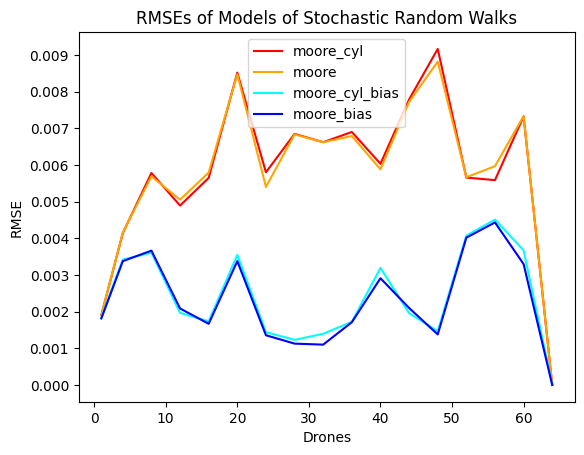

In [15]:
x_axis = np.arange(17) * 4
x_axis[0] = 1

x_labels = ['moore', 'moore_bias', 'moore_cyl', 'moore_cyl_bias']
x_colors = ['orange', 'blue', 'red', 'cyan']

plt.plot(x_axis, mses[2], label=x_labels[2], color=x_colors[2])
plt.plot(x_axis, mses[0], label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, mses[3], label=x_labels[3], color=x_colors[3])
plt.plot(x_axis, mses[1], label=x_labels[1], color=x_colors[1])

plt.title(f'RMSEs of Models of Stochastic Random Walks')
plt.xlabel('Drones')
plt.ylabel('RMSE')
plt.yticks(np.arange(0, 0.010, step=0.001))
plt.legend()

In [18]:
mses[3][32//4-1]

0.001229824877757246

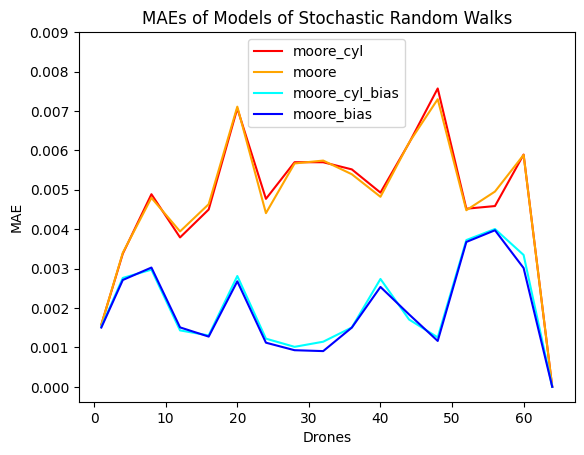

In [21]:
x_axis = np.arange(17) * 4
x_axis[0] = 1

x_labels = ['moore', 'moore_bias', 'moore_cyl', 'moore_cyl_bias']
x_colors = ['orange', 'blue', 'red', 'cyan']

plt.plot(x_axis, maes[2], label=x_labels[2], color=x_colors[2])
plt.plot(x_axis, maes[0], label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, maes[3], label=x_labels[3], color=x_colors[3])
plt.plot(x_axis, maes[1], label=x_labels[1], color=x_colors[1])

plt.title(f'MAEs of Models of Stochastic Random Walks')
plt.xlabel('Drones')
plt.ylabel('MAE')
plt.yticks(np.arange(0, 0.010, step=0.001))
plt.legend()

In [22]:
maes[3][32//4-1]

0.0010141887250898715

In [ ]:
moore_cyl_diff_mse = []
for t in range(0, 65, 4):
    DRONES = t if t > 0 else 1
    rwalk = random_walk_experiment(random_placement=1, use_motion=True)
    exp_mse = np.zeros(HMAP_TRIALS, dtype=float)
    for trial in range(HMAP_TRIALS):
        exp_mse[trial] = np.square(rwalk - heatmap_experiment(True, 0.175, 0.075)).mean()
    moore_cyl_diff_mse.append(exp_mse)

In [ ]:
for mse in moore_cyl_diff_mse:
    print(mse.mean(), mse.std())

In [42]:
def dist_to_mid(loc):
    return math.sqrt((loc[0] - MID)**2 + (loc[1] - MID)**2)


def get_best_neighbor_heat(turn, x, y, drone_id, whirl=0, drone_map=None, heat_map=None, use_max=False):
    if whirl == 1 and drone_id > 0 and turn <= 1:
        return (x, y)
    neighbors = get_neighbors(x, y, exclude_middle=True)
    
    if heat_map is None or len(heat_map) == 0:
        return rng.choice(neighbors)
    
    weights = [heat_map[neighbor[0], neighbor[1]] for neighbor in neighbors]
    if not (drone_map is None) and len(drone_map) > 0:
        weights_prime = []
        for i in range(len(weights)):
            if drone_map[neighbors[i][0], neighbors[i][1]] > 0:
                weights_prime.append(weights[i] * (1 - PHI))
            else:
                weights_prime.append(weights[i])
        weights = weights_prime
    
    if use_max:
        max_weight = max(weights)
        max_neighbors = list(map(lambda i: neighbors[i], filter(lambda i: max_weight - EPS <= weights[i] and weights[i] <= max_weight + EPS, range(len(weights)))))
        
        if len(max_neighbors) > 0:
#             max_neighbors.sort(key=dist_to_mid)
#             best_choice = dist_to_mid(max_neighbors[-1])
#             max_neighbors = list(filter(lambda loc: best_choice - EPS <= dist_to_mid(loc) and dist_to_mid(loc) <= best_choice + EPS, max_neighbors))
#             choice = rng.choice(max_neighbors)
#             max_neighbors.sort(key=lambda loc: get_shell_position(loc[0], loc[1])[1])
#             choice = max_neighbors[-1]
            shell, position = get_shell_position(x, y)
            max_neighbors_prime = list(filter(lambda loc: get_shell_position(loc[0], loc[1])[0] == shell, max_neighbors))
            if len(max_neighbors_prime) > 0:
                max_neighbors_prime.sort(key=lambda loc: get_shell_position(loc[0], loc[1])[1])
                choice = max_neighbors_prime[0]
                drone_map[choice[0], choice[1]] += 1
                return choice
            max_neighbors.sort(key=lambda loc: get_shell_position(loc[0], loc[1])[1])
            choice = max_neighbors[-1]
            drone_map[choice[0], choice[1]] += 1
            return choice

    norm = np.sum(weights)
    weights /= norm
    
    roll = rng.uniform(0, 1)
    for i in range(len(weights)):
        roll -= weights[i]
        if roll <= EPS:
            return neighbors[i]

    return neighbors[-1]


def sim_explore(is_cylindrical, ordinal_weight, diagonal_weight, random_placement=0, whirl=0, use_max=False, quad=False, use_loss=0):
    drones = place_drones(random_placement=random_placement, whirl=whirl, quad=quad)
    drone_map = np.zeros((GRID_SIZE, GRID_SIZE))
    for drone in drones:
        drone_map[drone[0], drone[1]] = 1
        
    tasks = place_tasks(random_placement=random_placement)
    num_tasks = len(tasks)
    
    heat_map = np.ones((GRID_SIZE, GRID_SIZE), dtype=float)
    heat_map[MID, MID] = 0
    
    loss_points = None
    if use_loss > 0:
        loss_points = list(sorted([rng.randint(1, TURNS + 1) for _ in range(use_loss)]))

    reward = np.zeros(TURNS + 1, dtype=float)
    for turn in range(1, TURNS + 1):
        for drone in drones:
            drone_map[drone[0], drone[1]] = 0
            
        if not (loss_points is None):
            while len(loss_points) > 0 and turn == loss_points[0]:
                drones.pop(rng.choice(list(range(len(drones)))))
                loss_points.pop(0)

        drones = [get_best_neighbor_heat(turn, drone[0], drone[1], i, whirl=whirl, drone_map=drone_map, heat_map=heat_map, use_max=use_max) for i, drone in enumerate(drones)]
        
        for drone in drones:
            drone_map[drone[0], drone[1]] = 0
        
        for i, drone in enumerate(drones):
            if whirl == 1 and i > 0 and turn <= 1:
                continue
            drone_map[drone[0], drone[1]] += 1
            heat_map[drone[0], drone[1]] *= (1 - PHI)
            
        tasks_t = []
        for task in tasks:
            if drone_map[task[0], task[1]] > 0 and rng.uniform(0, 1) < PHI:
                continue
            tasks_t.append(get_random_neighbor(task[0], task[1], use_alpha=True))
        tasks = tasks_t
        
        heat_map = apply_update(heat_map, is_cylindrical, ordinal_weight, diagonal_weight, use_alpha=True)
        
        reward[turn] = (num_tasks - len(tasks)) / num_tasks
    return reward


def explore_experiment(is_cylindrical, ordinal_weight, diagonal_weight, random_placement=0, use_max=False, whirl=0, quad=False, use_loss=0):
    final_reward = np.zeros(TURNS + 1, dtype=float)
    for trial in range(TRIALS):
        final_reward += sim_explore(is_cylindrical, ordinal_weight, diagonal_weight, random_placement=random_placement, use_max=use_max, whirl=whirl, quad=quad, use_loss=use_loss)
    final_reward /= TRIALS
    return final_reward

In [270]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.75
heat_explore_dynamic = explore_experiment(True, 0.175, 0.075, random_placement=1, use_max=True, quad=True)

In [264]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.75
whirl_explore_dynamic = random_walk_experiment(whirl=1, random_placement=1, use_motion=True)

In [265]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.75
mow_explore_dynamic = random_walk_experiment(mow=1, random_placement=1, use_motion=True)

In [271]:
[heat_explore_dynamic[-1], whirl_explore_dynamic[-1], mow_explore_dynamic[-1]]

[0.36361328125, 0.31865234375, 0.347705078125]

In [367]:
DRONES, TASKS, ALPHA, PHI = 32, 4096, 0.875, 0.75
random_explore_here = random_walk_experiment(random_placement=1, use_motion=True)
mow_explore_here = random_walk_experiment(mow=1, random_placement=1, use_motion=True)
whirl_explore_here = random_walk_experiment(whirl=1, random_placement=1, use_motion=True)
heat_explore_here = explore_experiment(True, 0.175, 0.075, random_placement=1, use_max=True, quad=True)
[random_explore_here[-1], mow_explore_here[-1], whirl_explore_here[-1], heat_explore_here[-1]]

[0.14126953125, 0.347646484375, 0.3165283203125, 0.358681640625]

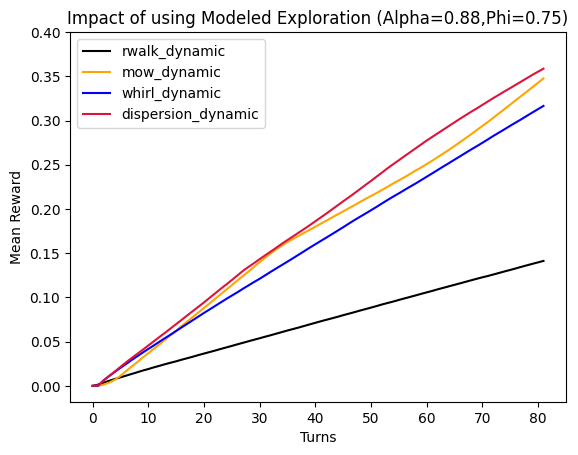

In [370]:
x_labels = ['rwalk_dynamic', 'mow_dynamic', 'whirl_dynamic', 'dispersion_dynamic']
x_colors = ['black', 'orange', 'blue', 'crimson']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, random_explore_here, label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, mow_explore_here, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, whirl_explore_here, label=x_labels[2], color=x_colors[2])
plt.plot(x_axis, heat_explore_here, label=x_labels[3], color=x_colors[3])

plt.title(f'Impact of using Modeled Exploration (Alpha={(1-ALPHA):.2f},Phi={PHI:.2f})')
plt.xlabel('Turns')
plt.ylabel('Mean Reward')
plt.yticks(np.arange(0, 0.45, step=0.05))
plt.legend()

In [371]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.75
random_explore_here = random_walk_experiment(random_placement=1, use_motion=True)
mow_explore_here = random_walk_experiment(mow=1, random_placement=1, use_motion=True)
whirl_explore_here = random_walk_experiment(whirl=1, random_placement=1, use_motion=True)
heat_explore_here = explore_experiment(True, 0.175, 0.075, random_placement=1, use_max=True, quad=True)
[random_explore_here[-1], mow_explore_here[-1], whirl_explore_here[-1], heat_explore_here[-1]]

[0.14125, 0.346650390625, 0.3142578125, 0.360546875]

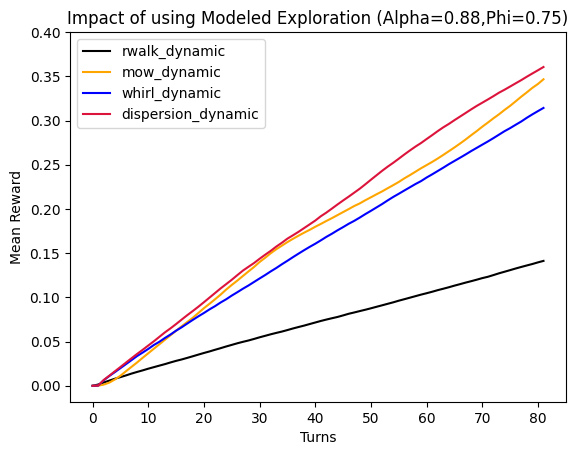

In [372]:
x_labels = ['rwalk_dynamic', 'mow_dynamic', 'whirl_dynamic', 'dispersion_dynamic']
x_colors = ['black', 'orange', 'blue', 'crimson']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, random_explore_here, label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, mow_explore_here, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, whirl_explore_here, label=x_labels[2], color=x_colors[2])
plt.plot(x_axis, heat_explore_here, label=x_labels[3], color=x_colors[3])

plt.title(f'Impact of using Modeled Exploration (Alpha={(1-ALPHA):.2f},Phi={PHI:.2f})')
plt.xlabel('Turns')
plt.ylabel('Mean Reward')
plt.yticks(np.arange(0, 0.45, step=0.05))
plt.legend()

In [373]:
DRONES, TASKS, ALPHA, PHI = 16, 1024, 0.875, 0.75
random_explore_here = random_walk_experiment(random_placement=1, use_motion=True)
mow_explore_here = random_walk_experiment(mow=1, random_placement=1, use_motion=True)
whirl_explore_here = random_walk_experiment(whirl=1, random_placement=1, use_motion=True)
heat_explore_here = explore_experiment(True, 0.175, 0.075, random_placement=1, use_max=True, quad=True)
[random_explore_here[-1], mow_explore_here[-1], whirl_explore_here[-1], heat_explore_here[-1]]

[0.101591796875, 0.195, 0.16265625, 0.196181640625]

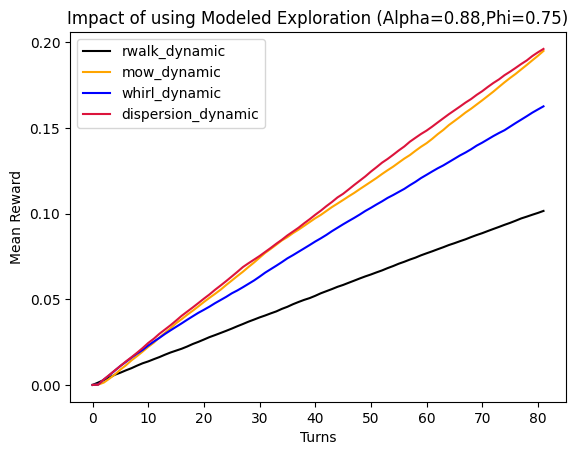

In [375]:
x_labels = ['rwalk_dynamic', 'mow_dynamic', 'whirl_dynamic', 'dispersion_dynamic']
x_colors = ['black', 'orange', 'blue', 'crimson']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, random_explore_here, label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, mow_explore_here, label=x_labels[1], color=x_colors[1])
plt.plot(x_axis, whirl_explore_here, label=x_labels[2], color=x_colors[2])
plt.plot(x_axis, heat_explore_here, label=x_labels[3], color=x_colors[3])

plt.title(f'Impact of using Modeled Exploration (Alpha={(1-ALPHA):.2f},Phi={PHI:.2f})')
plt.xlabel('Turns')
plt.ylabel('Mean Reward')
plt.yticks(np.arange(0, 0.25, step=0.05))
plt.legend()

In [38]:
data_randomwalk_64_32 = pd.read_csv('../logs/parser_ScenarioSize64Probes32RandomWalkB.csv')
data_quad_64_32 = pd.read_csv('../logs/parser_ScenarioSize64Probes32QuadSmgB.csv')

In [29]:
data_quad_64_32[(data_quad_64_32["Alpha"] == 0.125) & (data_quad_64_32["Beta"] == 0.875)]

,Scenario,Trial,Seed,Alpha,Beta,Gamma,Drones,Victims,Turn,Score
11480,ScenarioSize64Probes32QuadSmgB,141,880879381715801850,0.125,0.875,0.0,0,0,0.0,0.0000
11481,ScenarioSize64Probes32QuadSmgB,141,880879381715801850,0.125,0.875,0.0,0,2,20.0,0.0000
11482,ScenarioSize64Probes32QuadSmgB,141,880879381715801850,0.125,0.875,0.0,0,7,40.0,0.0000
11483,ScenarioSize64Probes32QuadSmgB,141,880879381715801850,0.125,0.875,0.0,0,11,60.0,0.0000
11484,ScenarioSize64Probes32QuadSmgB,141,880879381715801850,0.125,0.875,0.0,0,18,80.0,0.0000
...,...,...,...,...,...,...,...,...,...,...
12295,ScenarioSize64Probes32QuadSmgB,150,7094737511858396355,0.125,0.875,0.0,0,419,1540.0,0.0000
12296,ScenarioSize64Probes32QuadSmgB,150,7094737511858396355,0.125,0.875,0.0,0,419,1560.0,0.0000
12297,ScenarioSize64Probes32QuadSmgB,150,7094737511858396355,0.125,0.875,0.0,5,419,1580.0,0.0000
12298,ScenarioSize64Probes32QuadSmgB,150,7094737511858396355,0.125,0.875,0.0,32,419,1600.0,0.0000


In [39]:
report_headers = ['Scenario', 'Alpha', 'Beta', 'Gamma', 'Turn', 'Drones', 'Victims', 'Score']
groupby_headers = report_headers[:5]

In [40]:
report_randomwalk_64_32 = data_randomwalk_64_32[report_headers].groupby(groupby_headers).mean().reset_index()
report_randomwalk_64_32 = report_randomwalk_64_32.loc[report_randomwalk_64_32['Alpha'] == 0.125].loc[report_randomwalk_64_32['Beta'] == 0.875].reset_index()
report_randomwalk_64_32 = report_randomwalk_64_32['Victims'] / 1024
report_quad_64_32 = data_quad_64_32[report_headers].groupby(groupby_headers).mean().reset_index()
report_quad_64_32 = report_quad_64_32.loc[report_quad_64_32['Alpha'] == 0.125].loc[report_quad_64_32['Beta'] == 0.875].reset_index()
report_quad_64_32 = report_quad_64_32['Victims'] / 1024

In [43]:
DRONES, TASKS, ALPHA, PHI = 32, 1024, 0.875, 0.875
random_explore_here = random_walk_experiment(random_placement=1, use_motion=True)
heat_explore_here = explore_experiment(True, 0.175, 0.075, random_placement=1, use_max=True, quad=True)

In [34]:
[random_explore_here[-1], report_randomwalk_64_32[TURNS], heat_explore_here[-1], report_quad_64_32[TURNS]]

[0.14978515625, 0.15283203125, 0.403662109375, 0.38271484375]

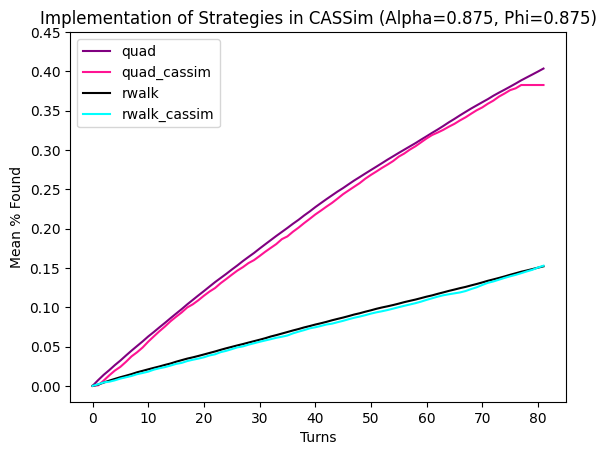

In [47]:
x_labels = ['rwalk', 'rwalk_cassim', 'quad', 'quad_cassim']
x_colors = ['black', 'cyan', 'purple', 'deeppink']
x_axis = np.arange(TURNS + 1)

plt.plot(x_axis, heat_explore_here, label=x_labels[2], color=x_colors[2])
plt.plot(x_axis, report_quad_64_32, label=x_labels[3], color=x_colors[3])
plt.plot(x_axis, random_explore_here, label=x_labels[0], color=x_colors[0])
plt.plot(x_axis, report_randomwalk_64_32, label=x_labels[1], color=x_colors[1])

plt.title(f'Implementation of Strategies in CASSim (Alpha=0.875, Phi=0.875)')
plt.xlabel('Turns')
plt.ylabel('Mean % Found')
plt.yticks(np.arange(0, 0.50, step=0.05))
plt.legend()